In [5]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("data/data/bank-note/train.csv", header=None)
d = df.to_numpy()
X = d[:,:-1]
x = np.hstack((X,np.ones((X.shape[0],1))))
y = d[:,-1] 
# y = np.expand_dims(d[:,-1], axis=-1) 

x.shape, y.shape

((872, 5), (872,))

In [7]:
df = pd.read_csv("data/data/bank-note/test.csv", header=None)
d = df.to_numpy()
x_test = d[:,:-1]
x_test = np.hstack((x_test,np.ones((x_test.shape[0],1))))

y_test = d[:,-1]
# y_test = np.expand_dims(d[:,-1], axis=-1) 

x_test.shape, y_test.shape

((500, 5), (500,))

# Part a

In [18]:
def get_output(weight, data, regression= "logistic"):
    """
        Output of different regression. Taken from Assignment 2.
        returns #examples x 1 arrays
    """
    dot_product = np.matmul(data,weight)
    if regression == "logistic":
        output = get_sigmoid(dot_product)
    elif regression == "probit":
        output = norm.cdf(dot_product)
    elif regression == "multiclass":
        output = softmax(dot_product, axis=1)

    return output, dot_product

def get_log_likelihood(phi, pred, t, dot_product, weight, reg= 1):
    """
        Returns log likelihood of the logistic regression
        t = N x 1
    """
    prior = -0.5* np.sum(np.multiply(weight, weight))
    likelihood = np.multiply(t, np.log(pred+TOLERANCE)) + np.multiply(1.0- t, np.log(1.0-pred+TOLERANCE))
    likelihood = np.sum(likelihood)

    return prior + likelihood

def get_sigmoid(x):
    """
        Numerically stable version of sigmoid function. Taken from Assignment 2.
    """  
    output = np.zeros(x.shape)
    ind1 = (x >= 0)
    ind2 = (x  < 0)
    output[ind1] = 1 / (1 + np.exp(-x[ind1]))
    output[ind2] = np.divide(np.exp(x[ind2]), (1 + np.exp(x[ind2])))

    return output

def get_gradient(phi, pred, t, dot_product, weight, reg= 1, regression= "logistic"):
    """
        Returns log likelihood of the logistic regression. Taken from Assignment 2
        t = (N, 1)
        weight = (D, 1)
    """
    if regression == "logistic":
        gradient = np.matmul(phi.T, pred - t)
    elif regression == "probit":
        R = np.eye(pred.shape[0])
        for i in range(pred.shape[0]):
            y_n  = pred[i,0]
            dotp = dot_product[i, 0]
            pdf  = norm.pdf(dotp)
            R[i,i] = pdf/(y_n*(1-y_n) + TOLERANCE)
        gradient = np.matmul(np.matmul(phi.T, R), pred-t)
    elif regression == "multiclass":
        gradient = np.matmul(phi.T, pred - t)

    # Add regularization
    gradient += weight/ reg
    return gradient

def get_KE(p, scale= 1):
    """ 
        Returns KE from the momentum vector
    """
    p = p.flatten()
    return scale * 0.5*np.sum(np.multiply(p, p))

def to_accept_without_log(x, x_new):
    """
        Acceptance rule without any log. 
    """
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        return (accept < x_new/(x+TOLERANCE))

def hybrid_monte_carlo(train_data, train_label, z_init, num_iterations, epsilon, num_leapfrog_steps, collect_final_sample_frequency= 10, display_frequency= 5000, scale_KE= 1):
    """
        Gets posterior samples for Bayes Logistic Regression using HMC algorithm
        z_int= (dim, 1)
    """
    dim = train_data.shape[1]
    z = z_init

    accepted = [] # Keeps track of accepted samples
    sampled  = [] # Keeps track of all samples
    final    = [] # Keeps track of final samples which are sampled in a cyclic manner
    
    for i in range(num_iterations):
        # Old energy = -loglik and Old gradient
        pred, dot_product = get_output(z, train_data)
        old_PE   =  -get_log_likelihood(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= z)
        
        # There is no minus since gradient function returns gradient of negative log likelihood
        old_grad =  get_gradient(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= z)

        new_z = np.copy(z)              # deep copy of array
        new_grad  = np.copy(old_grad)   # deep copy of array

        # draw random momentum vector from unit Gaussian which decides the energy
        # given out for exploration
        p = np.random.normal(0.0, 1.0, (dim, 1))

        # Compute Hamiltonian
        H = get_KE(p, scale= scale_KE) + old_PE

        # Suggest new candidate using gradient + Hamiltonian dynamics.
        # Leapfrog
        for j in range(num_leapfrog_steps):  
            # Make first half step in p, full step in z and then again half step in p
            p        -= (epsilon/2.0)*new_grad
            new_z    += epsilon*p
            pred, dot_product = get_output(new_z, train_data)
            new_grad  = get_gradient(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= new_z)
            p        -= (epsilon/2.0)*new_grad

        # Compute new Hamiltonian
        pred, dot_product = get_output(new_z, train_data)
        new_PE = -get_log_likelihood(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= new_z)
        new_H  = get_KE(p, scale= scale_KE) + new_PE
        
        sampled.append(new_z)
        
        # Accept new candidate in Monte-Carlo fashion.
        if to_accept_without_log(get_prob_from_energy(H), get_prob_from_energy(new_H)):            
            z = new_z
            accepted.append(new_z)

        if i % collect_final_sample_frequency == 0:
            # Sample from the current parameters
            final.append(z)

        if (i+1) % display_frequency == 0 or i == num_iterations-1:
            print("Iter {:6d} done".format(i+1))
    
    return np.array(accepted), np.array(sampled), np.array(final), z

def get_prob_from_energy(energy):
    return np.exp(-energy)

def get_accuracy(pred, test_label, regression= "logistic"):
    """
        Gets accuracy in % for predictions. Taken from Assignment 2.
    """
    if regression == "multiclass":
        pred_max = np.argmax(pred, axis=1)
        gt_max   = np.argmax(test_label, axis=1)
        acc = np.sum(pred_max == gt_max)*100.0/pred.shape[0]
    elif regression == "logistic" or regression == "probit":
        if pred.ndim == 2:
            pred = pred[:,0]
        pred[pred >= 0.5] = 1.0
        pred[pred <  0.5] = 0.0
    acc = np.sum(pred == test_label)*100.0/pred.shape[0]

    return acc

def get_prediction_likelihood_without_complications(test_data, test_label, weight):
    """
        Returns prediction likelihood on a sample weight without using any hessian
        test_data  = N x D
        test_label = N 
        weight     = D x 1
    """
    pred, _ = get_output(weight, test_data)
    pred = pred[:,0]
    pred_like = np.multiply(test_label, np.log(pred + TOLERANCE)) + np.multiply(1.0-test_label, np.log(1.0-pred+ TOLERANCE))
    return np.exp(np.mean(pred_like))

def test_on_posterior(test_data, test_label, posterior_samples):
    """
        Returns stats on posterior samples
    """
    print("Testing on posterior samples...")
    num_posterior_samples = posterior_samples.shape[0]
    avg_pred_test    = np.zeros((num_posterior_samples, ))
    avg_pred_log_lld = np.zeros((num_posterior_samples, ))
                    
    for k in range(num_posterior_samples):
        # Use the posterior samples
        w_sampled = posterior_samples[k]
        
        # Get the hessian
        #pred, dot_product = get_output(w_sampled, train_data)
        #hessian  = get_hessian (phi= train_data, pred= pred[:, np.newaxis], t= train_label[:, np.newaxis], dot_product= dot_product)
        
        pred_test, _         = get_output  (w_sampled, test_data)
        acc                  = get_accuracy(pred_test, test_label) 
        pred_likelihood      = get_prediction_likelihood_without_complications(test_data, test_label, w_sampled) #get_prediction_likelihood(test_data, test_label, w_sampled, hessian)
        avg_pred_test[k]     = acc
        avg_pred_log_lld [k] = np.log(pred_likelihood)
        
        if (k+1)%100 == 0 or k== num_posterior_samples-1:
            print("{:5d} Posterior Weight samples Test_data Pred_acc= {:.2f}, Pred_log_likelihood= {:.2f}".format(k+1, np.mean(avg_pred_test[:k]), np.mean(avg_pred_log_lld[:k])))    

In [19]:
dim = x.shape[1]

num_iterations       = 100000#//10
num_iterations_final = 10000 #//10
collect_final_sample_frequency = 10
display_frequency    = 5000
TOLERANCE = 1e-5

print("\n=======================================================================")
print("\tHamiltonian Monte Carlo Sampling with Leapfrog")
print("=======================================================================")
epsilon_array = np.array([0.005, 0.01, 0.02, 0.05])
num_leapfrog_steps_array = np.array([10, 20, 50])

for i in range(epsilon_array.shape[0]):
    for j in range(num_leapfrog_steps_array.shape[0]):
        epsilon            = epsilon_array[i]
        num_leapfrog_steps = num_leapfrog_steps_array[j]
        print("\nBurnin stage, epsilon = {:.3f}, L= {}".format(epsilon, num_leapfrog_steps))
        w_init = np.zeros((dim, 1))
        _, _, _, w_new = hybrid_monte_carlo(x, y, z_init= w_init, num_iterations= num_iterations, 
                                            epsilon= epsilon, num_leapfrog_steps= num_leapfrog_steps, 
                                            collect_final_sample_frequency= collect_final_sample_frequency, 
                                            scale_KE= 1)

        # Remember to initialize from new values
        print("Generating samples after burnin stage...")
        accepted, sampled, posterior_samples, _ = hybrid_monte_carlo(x, y, z_init= w_new , 
                                                                     num_iterations= num_iterations_final, 
                                                                     epsilon= epsilon, 
                                                                     num_leapfrog_steps= num_leapfrog_steps, 
                                                                     collect_final_sample_frequency= collect_final_sample_frequency,
                                                                     scale_KE= 1)
        acceptance_rate = accepted.shape[0]/sampled.shape[0]
        test_on_posterior(x_test, y_test, posterior_samples)
        print("Acceptance rate= {:2f}".format(acceptance_rate))


	Hamiltonian Monte Carlo Sampling with Leapfrog

Burnin stage, epsilon = 0.005, L= 10
Iter   5000 done
Iter  10000 done
Iter  15000 done
Iter  20000 done
Iter  25000 done
Iter  30000 done
Iter  35000 done
Iter  40000 done
Iter  45000 done
Iter  50000 done
Iter  55000 done
Iter  60000 done
Iter  65000 done
Iter  70000 done
Iter  75000 done
Iter  80000 done
Iter  85000 done
Iter  90000 done
Iter  95000 done
Iter 100000 done
Generating samples after burnin stage...
Iter   5000 done
Iter  10000 done
Testing on posterior samples...
  100 Posterior Weight samples Test_data Pred_acc= 99.00, Pred_log_likelihood= -0.04
  200 Posterior Weight samples Test_data Pred_acc= 99.00, Pred_log_likelihood= -0.04
  300 Posterior Weight samples Test_data Pred_acc= 99.00, Pred_log_likelihood= -0.04
  400 Posterior Weight samples Test_data Pred_acc= 99.00, Pred_log_likelihood= -0.04
  500 Posterior Weight samples Test_data Pred_acc= 99.00, Pred_log_likelihood= -0.04
  600 Posterior Weight samples Test_data 

Iter   5000 done
Iter  10000 done
Iter  15000 done
Iter  20000 done
Iter  25000 done
Iter  30000 done
Iter  35000 done
Iter  40000 done
Iter  45000 done
Iter  50000 done
Iter  55000 done
Iter  60000 done
Iter  65000 done
Iter  70000 done
Iter  75000 done
Iter  80000 done
Iter  85000 done
Iter  90000 done
Iter  95000 done
Iter 100000 done
Generating samples after burnin stage...
Iter   5000 done
Iter  10000 done
Testing on posterior samples...
  100 Posterior Weight samples Test_data Pred_acc= 98.95, Pred_log_likelihood= -0.03
  200 Posterior Weight samples Test_data Pred_acc= 98.95, Pred_log_likelihood= -0.03
  300 Posterior Weight samples Test_data Pred_acc= 98.95, Pred_log_likelihood= -0.03
  400 Posterior Weight samples Test_data Pred_acc= 98.96, Pred_log_likelihood= -0.03
  500 Posterior Weight samples Test_data Pred_acc= 98.96, Pred_log_likelihood= -0.03
  600 Posterior Weight samples Test_data Pred_acc= 98.96, Pred_log_likelihood= -0.03
  700 Posterior Weight samples Test_data Pr

# Part c

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.utils.data.dataset import Dataset
import csv

max_epoch       = 1000
workers         = 4
train_batch_size= 872
test_batch_size = 500
log_iter        = 100

TOLERANCE    = 1e-5
input_dim    = 5
n_class      = 2
SAMPLES      = 100
TEST_SAMPLES = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

lr         = 0.001
n_hidden   = 20
activation = 'relu'

class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu     = mu
        self.rho    = rho
        self.normal = torch.distributions.Normal(0, 1)

    @property
    def sigma(self):
        #return torch.sqrt(torch.log(1+torch.exp(self.rho))+TOLERANCE)
        return (torch.log(torch.exp(self.rho))+TOLERANCE)

    def sample(self):
        epsilon = self.normal.sample(self.rho.shape).type(self.mu.type()).to(device)
        return self.mu + self.sigma * epsilon

    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

class StandardGaussian(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma
        self.gaussian = torch.distributions.Normal(0, self.sigma)

    def log_prob(self, input):
        return (self.gaussian.log_prob(input)).sum()

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        alpha = 1.0 / np.sqrt(self.in_features)

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.ones(out_features, in_features)*alpha)
        self.weight     = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu    = nn.Parameter(torch.zeros(out_features))
        self.bias_rho   = nn.Parameter(torch.ones(out_features)*alpha)
        self.bias       = Gaussian(self.bias_mu, self.bias_rho)

        # Prior distributions
        self.weight_prior = StandardGaussian(1)#ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)#
        self.bias_prior = StandardGaussian(1)#ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)#StandardGaussian(1)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)


class BayesianNetwork(nn.Module):
    def __init__(self, n_hidden, activation):
        super().__init__()
        self.l1 = BayesianLinear(input_dim, n_hidden)
        self.l2 = BayesianLinear(n_hidden, n_hidden)
        self.l3 = BayesianLinear(n_hidden, n_class)
        if(activation=='relu'):
            self.activation_fn = nn.ReLU()
        else:
            self.activation_fn = nn.Tanh()

    def forward(self, x, sample=False):
        x = self.activation_fn(self.l1(x, sample))
        x = self.activation_fn(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x

    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior

    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior

    def sample_elbo(self, input, target, samples=SAMPLES):

        outputs = torch.zeros(samples, input.shape[0], n_class).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        for i in range(samples):
            outputs[i] = self.forward(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        outputs = outputs.mean(dim= 0)
        neg_log_like = F.nll_loss(outputs, target, reduction='mean')
        loss = neg_log_like #+ (log_variational_posterior-log_prior)
        pred = outputs.argmax(dim= 1)
        train_acc = ((pred.eq(target.view_as(pred)).sum())*100.0)/target.shape[0]
        return loss, train_acc

def train(net, train_loader, optimizer, epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target   = data.to(device), target.to(device)
        net.zero_grad()
        loss, train_acc = net.sample_elbo(data, target, samples=SAMPLES)
        if(epoch%log_iter==0):
            print("Epoch : {:4d} \t Training Loss : {:6.4f} \t Training Accuracy : {:4.2f}%".format(epoch, loss, train_acc))
        loss.backward()
        optimizer.step()

def predictive_accuracy(net, test_loader):
    net.eval()
    with torch.no_grad():
        test_acc = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target   = data.to(device), target.to(device)
            outputs = torch.zeros(TEST_SAMPLES, data.shape[0], n_class).to(device)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
                pred = outputs[i].argmax(dim=1)
                test_acc += ((pred.eq(target.view_as(pred)).sum()) * 100.0) / target.shape[0]
                #print(test_acc)
            #outputs = outputs.mean(0)
            #pred = outputs.argmax(dim=1)
            #test_acc = (torch.sum(pred == target) * 100.0) / target.shape[0]
        test_acc = test_acc/TEST_SAMPLES
    return test_acc

def predictive_log_likelihood(net, test_loader):
    net.eval()
    with torch.no_grad():
        pred_like = 0
        counter = 0

        for batch_idx, (data, target) in enumerate(test_loader):
            #print(target.shape)
            data, target   = data.to(device), target.float().to(device)
            outputs = torch.zeros(TEST_SAMPLES, data.shape[0], n_class).to(device)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            output = torch.sum(outputs, axis = 0)/TEST_SAMPLES
            pred_like += torch.mean(target*output[:,1] + (1-target)*output[:,0])
            counter+=1
        pred_like = pred_like/counter
    return pred_like

def read_csv(filename):
    x=[]
    y=[]
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for i in csv_reader :
            x.append(i[0:-1])
            y.append(i[-1])
    x = np.array(x).astype(np.float)
    x = np.hstack((x,np.ones((x.shape[0],1))))		#for the bias term
    y = np.array(y).astype(np.float)
    return (x,y)

def norm_data(x):
    #To normalise the data within [-1, 1]
    x =  (x - np.mean(x, axis=0))*(1/(np.max(x,axis=0) - np.min(x, axis=0)))    #max(x) = 0.47, min(x) = -0.53
    return(x)

class BankData(Dataset):
    def __init__(self, filename):
        x, y = read_csv(filename)
        #x[:, :-1] = norm_data(x[:, :-1])
        self.X, self.Y = x, y

    def __getitem__(self, index):

        x = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.Y[index]).long()
        return (x, y)

    def __len__(self):
        return self.X.shape[0]

cuda





Activation Function : relu 	Hidden Layer Size : 10 	Learning rate : 0.001



/tmp/ipykernel_3704/795300853.py:197: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(x).astype(np.float)
/tmp/ipykernel_3704/795300853.py:199: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y).astype(np.float)


Epoch :  100 	 Training Loss : 0.7761 	 Trainig Accuracy : 55.39%
Epoch :  200 	 Training Loss : 0.7164 	 Trainig Accuracy : 55.39%
Epoch :  300 	 Training Loss : 0.7040 	 Trainig Accuracy : 55.39%
Epoch :  400 	 Training Loss : 0.6923 	 Trainig Accuracy : 55.39%
Epoch :  500 	 Training Loss : 0.6945 	 Trainig Accuracy : 55.39%
Epoch :  600 	 Training Loss : 0.6885 	 Trainig Accuracy : 55.39%
Epoch :  700 	 Training Loss : 0.6769 	 Trainig Accuracy : 55.39%
Epoch :  800 	 Training Loss : 0.6106 	 Trainig Accuracy : 66.28%
Epoch :  900 	 Training Loss : 0.3039 	 Trainig Accuracy : 95.64%
Epoch : 1000 	 Training Loss : 0.1590 	 Trainig Accuracy : 98.85%

 Predictive Accuracy : 98.3460 	Predictive Log Likelihood : -0.1529


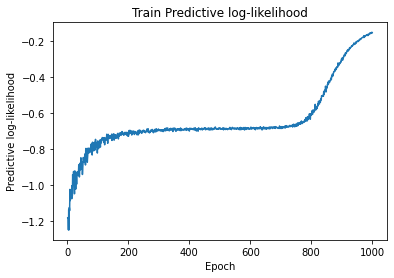

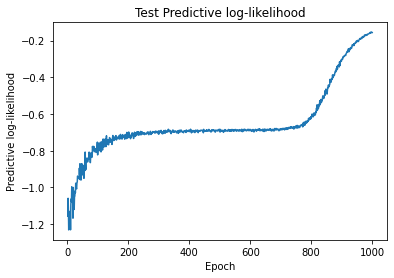




Activation Function : relu 	Hidden Layer Size : 20 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.7311 	 Trainig Accuracy : 55.39%
Epoch :  200 	 Training Loss : 0.6918 	 Trainig Accuracy : 55.39%
Epoch :  300 	 Training Loss : 0.6907 	 Trainig Accuracy : 55.39%
Epoch :  400 	 Training Loss : 0.6910 	 Trainig Accuracy : 55.39%
Epoch :  500 	 Training Loss : 0.6887 	 Trainig Accuracy : 55.39%
Epoch :  600 	 Training Loss : 0.6744 	 Trainig Accuracy : 55.39%
Epoch :  700 	 Training Loss : 0.5229 	 Trainig Accuracy : 80.05%
Epoch :  800 	 Training Loss : 0.2430 	 Trainig Accuracy : 97.36%
Epoch :  900 	 Training Loss : 0.1419 	 Trainig Accuracy : 98.97%
Epoch : 1000 	 Training Loss : 0.1038 	 Trainig Accuracy : 99.31%

 Predictive Accuracy : 99.3380 	Predictive Log Likelihood : -0.1019


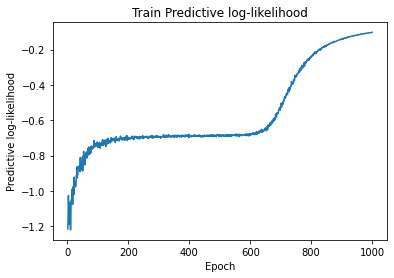

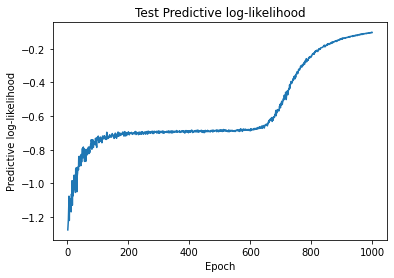




Activation Function : relu 	Hidden Layer Size : 50 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.7253 	 Trainig Accuracy : 55.39%
Epoch :  200 	 Training Loss : 0.6954 	 Trainig Accuracy : 55.39%
Epoch :  300 	 Training Loss : 0.6891 	 Trainig Accuracy : 55.39%
Epoch :  400 	 Training Loss : 0.6831 	 Trainig Accuracy : 55.39%
Epoch :  500 	 Training Loss : 0.5412 	 Trainig Accuracy : 68.23%
Epoch :  600 	 Training Loss : 0.2567 	 Trainig Accuracy : 97.36%
Epoch :  700 	 Training Loss : 0.1616 	 Trainig Accuracy : 98.74%
Epoch :  800 	 Training Loss : 0.1223 	 Trainig Accuracy : 99.20%
Epoch :  900 	 Training Loss : 0.0965 	 Trainig Accuracy : 100.00%
Epoch : 1000 	 Training Loss : 0.0771 	 Trainig Accuracy : 100.00%

 Predictive Accuracy : 99.6260 	Predictive Log Likelihood : -0.0790


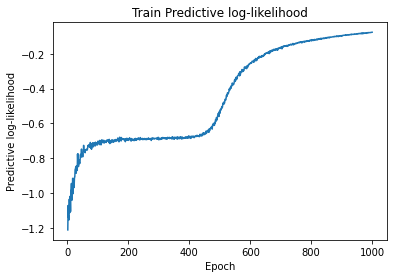

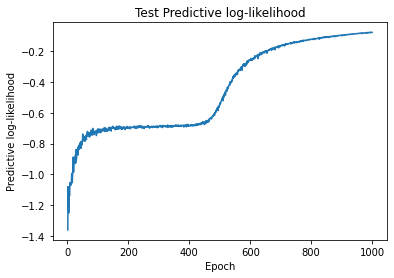




Activation Function : tanh 	Hidden Layer Size : 10 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.7445 	 Trainig Accuracy : 55.39%
Epoch :  200 	 Training Loss : 0.7174 	 Trainig Accuracy : 55.39%
Epoch :  300 	 Training Loss : 0.7005 	 Trainig Accuracy : 55.39%
Epoch :  400 	 Training Loss : 0.6944 	 Trainig Accuracy : 55.39%
Epoch :  500 	 Training Loss : 0.6877 	 Trainig Accuracy : 55.39%
Epoch :  600 	 Training Loss : 0.6892 	 Trainig Accuracy : 55.39%
Epoch :  700 	 Training Loss : 0.6859 	 Trainig Accuracy : 55.39%
Epoch :  800 	 Training Loss : 0.4378 	 Trainig Accuracy : 94.84%
Epoch :  900 	 Training Loss : 0.0353 	 Trainig Accuracy : 99.20%
Epoch : 1000 	 Training Loss : 0.0205 	 Trainig Accuracy : 99.43%

 Predictive Accuracy : 99.3360 	Predictive Log Likelihood : -0.0222


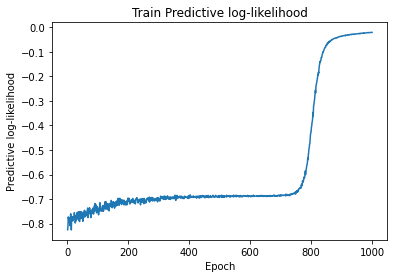

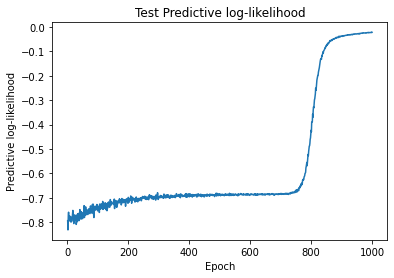




Activation Function : tanh 	Hidden Layer Size : 20 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.7231 	 Trainig Accuracy : 55.39%
Epoch :  200 	 Training Loss : 0.6986 	 Trainig Accuracy : 55.39%
Epoch :  300 	 Training Loss : 0.6882 	 Trainig Accuracy : 55.39%
Epoch :  400 	 Training Loss : 0.6885 	 Trainig Accuracy : 55.39%
Epoch :  500 	 Training Loss : 0.6864 	 Trainig Accuracy : 55.39%
Epoch :  600 	 Training Loss : 0.6564 	 Trainig Accuracy : 55.50%
Epoch :  700 	 Training Loss : 0.0675 	 Trainig Accuracy : 99.08%
Epoch :  800 	 Training Loss : 0.0246 	 Trainig Accuracy : 99.08%
Epoch :  900 	 Training Loss : 0.0141 	 Trainig Accuracy : 99.43%
Epoch : 1000 	 Training Loss : 0.0076 	 Trainig Accuracy : 99.89%

 Predictive Accuracy : 99.8940 	Predictive Log Likelihood : -0.0093


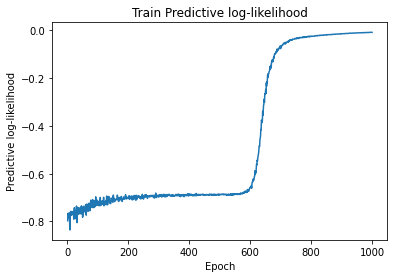

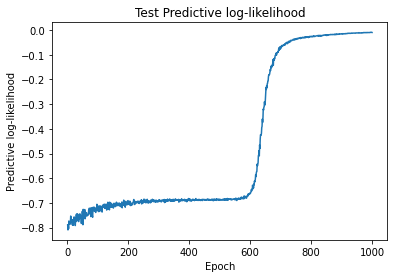




Activation Function : tanh 	Hidden Layer Size : 50 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.7377 	 Trainig Accuracy : 55.39%
Epoch :  200 	 Training Loss : 0.6932 	 Trainig Accuracy : 55.39%
Epoch :  300 	 Training Loss : 0.6682 	 Trainig Accuracy : 55.39%
Epoch :  400 	 Training Loss : 0.1203 	 Trainig Accuracy : 98.28%
Epoch :  500 	 Training Loss : 0.0346 	 Trainig Accuracy : 99.08%
Epoch :  600 	 Training Loss : 0.0192 	 Trainig Accuracy : 99.43%
Epoch :  700 	 Training Loss : 0.0123 	 Trainig Accuracy : 99.89%
Epoch :  800 	 Training Loss : 0.0088 	 Trainig Accuracy : 99.89%
Epoch :  900 	 Training Loss : 0.0066 	 Trainig Accuracy : 100.00%
Epoch : 1000 	 Training Loss : 0.0040 	 Trainig Accuracy : 100.00%

 Predictive Accuracy : 99.9280 	Predictive Log Likelihood : -0.0054


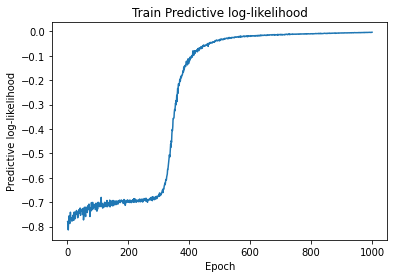

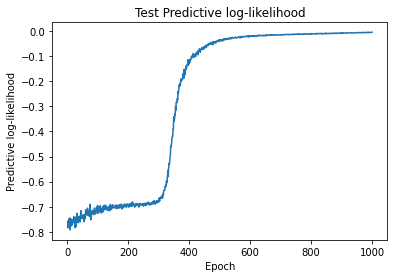

In [24]:
train_filename= "data/data/bank-note/train.csv"
test_filename = "data/data/bank-note/test.csv"

train_data    = BankData(train_filename)
train_loader  = torch.utils.data.DataLoader(dataset= train_data,  batch_size= train_batch_size, shuffle= True , num_workers = workers)

test_data     = BankData(test_filename)
test_loader   = torch.utils.data.DataLoader(dataset= test_data,  batch_size= test_batch_size, shuffle= False, num_workers = workers)
n_hidden_val = [10, 20, 50]
activation_val = ['relu', 'tanh']
for activation in activation_val:
    for n_hidden in n_hidden_val:
        #for lr in lr_val:
        net = BayesianNetwork(n_hidden= n_hidden, activation= activation).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr = lr)
        print("\n\n==============================================================================\n")
        print("Activation Function : {} \tHidden Layer Size : {} \tLearning rate : {}\n".format(activation, n_hidden, lr))
        train_like = []
        test_like = []
        for epoch in range(1,max_epoch+1):
            train(net, train_loader, optimizer, epoch)
            train_like.append(predictive_log_likelihood(net, train_loader).cpu())
            test_like.append(predictive_log_likelihood(net, test_loader).cpu())
        pred_acc = predictive_accuracy(net, test_loader)
        pred_like = predictive_log_likelihood(net, test_loader)
        print("\n Predictive Accuracy : {:.4f} \tPredictive Log Likelihood : {:.4f}".format(pred_acc, pred_like))

        plt.plot(np.arange(max_epoch)+1, train_like)
        plt.title("Train Predictive log-likelihood")
        plt.xlabel("Epoch")
        plt.ylabel("Predictive log-likelihood")
        plt.show()
        
    
        plt.plot(np.arange(max_epoch) + 1, test_like)
        plt.title("Test Predictive log-likelihood")
        plt.xlabel("Epoch")
        plt.ylabel("Predictive log-likelihood")
        plt.show()